In [1]:
import os
from tqdm import tqdm
from PIL import Image

import pandas as pd

import torch
import torch.nn as nn

from torchvision.models import resnet50
import torchvision.transforms as transforms

In [2]:
dataset_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

is_cuda = torch.cuda.is_available()

print('Torch Version : {}'.format(torch.__version__))
print('CUDA Available : {}'.format(is_cuda))
if is_cuda :
    print('Torch Device : {}'.format(torch.cuda.get_device_name()))

device = 'cuda' if is_cuda else 'cpu'

Torch Version : 1.7.1+cu110
CUDA Available : True
Torch Device : GeForce RTX 2070 SUPER


In [3]:
result_df = pd.DataFrame(columns=['image', 'level'])

In [4]:
model = resnet50()
for param in model.parameters() :
    param.requires_grad = False

model.fc = nn.Linear(2048, 5, bias=True)
model.load_state_dict(torch.load('day3mission.pt'))
model = model.to(device)

In [5]:
test_folder = 'E:/diabetic-retinopathy-detection/test'

test_file_list = os.listdir(test_folder)
len(test_file_list)

53576

In [7]:
tmp_img = Image.open('E:/diabetic-retinopathy-detection/test/' + test_file_list[0])
tmp_img = dataset_transform(tmp_img)
tmp_img.shape

torch.Size([3, 224, 224])

In [32]:
from torch.utils.data import Dataset, DataLoader


class ImageTestDataset(Dataset) :
  def __init__(self, root_dir='E:/diabetic-retinopathy-detection/test/', transform=dataset_transform) :
    self.root_dir = root_dir
    self.file_list = os.listdir(root_dir)
    self.transform = transform

  def __len__(self) :
    return len(self.file_list)

  def __getitem__(self, index):
    img_path = os.path.join(self.root_dir, self.file_list[index])
    img = Image.open(img_path)
    
    if self.transform :
      img = self.transform(img)
    
    return img, self.file_list[index][:-5]

In [33]:
test_dataset = ImageTestDataset()
test_dataset.__len__()

53576

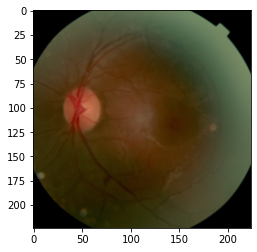

In [11]:
import matplotlib.pyplot as plt

plt.imshow(test_dataset[0].permute(1,2,0))

In [34]:
test_dataloader = DataLoader(test_dataset, batch_size=64)

In [42]:
model.eval()

images = []
levels = []

for x_test, x_name in tqdm(test_dataloader) :
    x_test = x_test.to(device)

    output = model(x_test)
    _, pred = output.max(1)
    
    images.extend(x_name)
    levels.extend(pred.tolist())


100%|██████████| 838/838 [1:07:20<00:00,  4.82s/it]


In [43]:
result_df = pd.DataFrame({'image':images, 'level':levels})
result_df

,image,level
0,10000_left,0
1,10000_right,0
2,10001_left,0
3,10001_right,0
4,10002_left,0
...,...,...
53571,9997_right,0
53572,999_left,0
53573,999_right,0
53574,9_left,0


In [46]:
result_df.set_index('image').to_csv('submisssion.csv')